In [1]:
import xarray
import intake
import numpy as np

In [2]:
number_in_cluster = 10

%run start_cluster.ipynb 
client = get_dask_cluster(number_in_cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://nebari.rpsgroup.com/gateway/clusters/dev.948c11e709344e7c975e43f4a9a9fd48/status,


In [3]:

catalog = intake.open_catalog('s3://ncdis-ra/ncdis_intake.yml')
list(catalog)
cat_entry = 'NCDIS-WaterLevel-1979-2021'
ds = catalog[cat_entry].to_dask()
ds

<xarray.Dataset>
Dimensions:      (mesh: 1, node: 1813443, nele: 3564104, nvertex: 3, nbou: 186,
                  time: 376943, nope: 1, max_nvdll_dim: 186,
                  max_nvell_dim: 57146)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01T01:00:00 ... 2021-12-31T23:...
    x            (node) float64 dask.array<chunksize=(160000,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(160000,), meta=np.ndarray>
Dimensions without coordinates: mesh, node, nele, nvertex, nbou, nope,
                                max_nvdll_dim, max_nvell_dim
Data variables: (12/14)
    adcirc_mesh  (mesh) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    depth        (node) float64 dask.array<chunksize=(160000,), meta=np.ndarray>
    element      (nele, nvertex) float64 dask.array<chunksize=(891026, 1), meta=np.ndarray>
    ibtype       (nbou) float64 dask.array<chunksize=(186,), meta=np.ndarray>
    ibtypee      (time, nope) float64 dask.array<chunksize=(240, 1), meta=np.ndarray>
    max_nvdll    (time) float64 dask.array<chunksize=(240,), meta=np.ndarray>
    ...           ...
    nbvv         (max_nvell_dim, nbou) float64 dask.array<chunksize=(14287, 47), meta=np.ndarray>
    neta         float64 ...
    nvdll        (nope) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nvel         float64 ...
    nvell        (nbou) float64 dask.array<chunksize=(186,), meta=np.ndarray>
    zeta         (time, node) float64 dask.array<chunksize=(240, 160000), meta=np.ndarray>
Attributes: (12/49)
    Conventions:        UGRID-0.9.0
    NCO:                netCDF Operators version 4.7.5 (Homepage = http://nco...
    a00:                0.0
    agrid:              NOMAD mesh v1e MSL - fixed bahamas bathy
    b00:                1.0
    c00:                0.0
    ...                 ...
    slam0:              265.5
    source:             RENCI_HPC
    statim:             0.0
    tau0:               -3.0
    title:              NOAA-Reanalysis-Post
    version:            v53-dev-238-g62e8042-modified

In [4]:
lon_min = -76
lon_max = -62
lat_min = 30.5
lat_max = 35
min_time = '1980-07-01'
max_time = '1980-9-01'




# file to write the output to. 
output_file_name = cat_entry+'_subset.nc'

#  all_triangle_nodes_in_bbox : True/False
#  True means only export if all nodes of the triangle are in the bounding box
#  False means export all nodes of a triangle if any node is in the bounding box
all_triangle_nodes_in_bbox = True # True/False 



In [5]:
%%time
# Subset the data by time and AOI
# Write the resulting data to a local netCDF file

e = ds.element.values.astype(int) - 1
dsx_e = ds.x.values[e]
dsy_e = ds.y.values[e]

lon_in_bounds = np.logical_and(dsx_e>=lon_min,dsx_e<=lon_max)

lat_in_bounds = np.logical_and(dsy_e>=lat_min, dsy_e<=lat_max)

if all_triangle_nodes_in_bbox:
    lats_in = np.all(lat_in_bounds,axis=1)
    lons_in = np.all(lon_in_bounds,axis=1)
else:
    lats_in = np.any(lat_in_bounds,axis=1)
    lons_in = np.any(lon_in_bounds,axis=1)   
element_mask = (lons_in & lats_in)
extract_nodes = np.where(element_mask)[0]
unique_nodes = np.unique(e[extract_nodes])
print(unique_nodes)
print("about to subset")
# subset based on AOI and time frame
ds_u =ds.sel(time=slice(min_time,max_time),
             node=unique_nodes,nele=extract_nodes).compute()

print("Nodes: ",len(unique_nodes), " Timesteps: ",ds_u.dims['time'])
new_e_updated=np.searchsorted(unique_nodes,e[extract_nodes])
ds_u['element'].data = new_e_updated + 1
ds_u.to_netcdf(cat_entry+'_subset.nc',engine="netcdf4")
ds_u.close
ds.close()
print("Wrote subset to: ", output_file_name)

[1477363 1477364 1480200 ... 1604310 1604311 1604312]
about to subset
Nodes:  5229  Timesteps:  1512
Wrote subset to:  NCDIS-WaterLevel-1979-2021_subset.nc
CPU times: user 26.5 s, sys: 14.8 s, total: 41.3 s
Wall time: 1min 49s


In [10]:
del ds

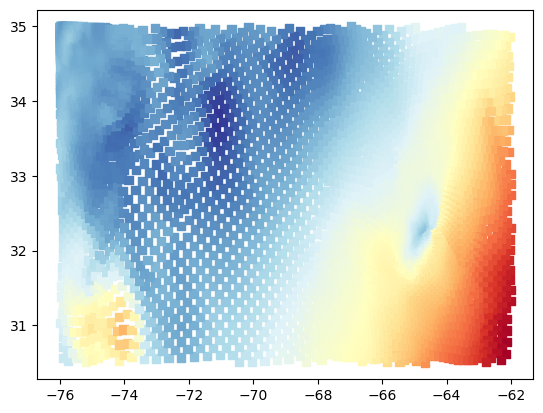

In [6]:
# Plot data from new subset file
import xarray
import matplotlib.pyplot as plt
ds = xarray.open_dataset(output_file_name)
time_index = 0
plt.scatter(ds.x,ds.y,c=ds.zeta[time_index,:],cmap="RdYlBu",marker=",")
ds.close()



In [17]:
# Shutdown the dask gateway
from dask_gateway import Gateway
gateway = Gateway()
for c in gateway.list_clusters():
    print(c.name)
    gateway.connect(c.name).close(shutdown=True)

dev.8e57858962a64d24926341414f9bbbbb


/home/conda/nebari-git/fd2e1eff2be0ea4dee3df3264d8792afb059f540a4e70ca9a6857eb78b7aa8a1-20230316-203712-251993-22-dask-analysis/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()
